# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')

from pynistview_utils import *

# Set up directories and files

In [2]:
# Configure input files

indir = "/Users/rmoraski/Documents/iCloud/School/Electrons/NISTView-ish/"

im_suffix, m1_suffix, m2_suffix = "_ix.sempa", "_mx.sempa", "_my.sempa"
#im_suffix, m1_suffix, m2_suffix = "_ix2.sempa", "_mx2.sempa", "_mz.sempa"

name = "191001_Fe_whisker/Fe_whisker"
#name = "FeGd_Nov_Dec/171117_FeGd"
#name = "FeGd_Nov_Dec/FeGd100"
#name = "FeGd_Nov_Dec/FeGd200"

run = 2

full_name = name + f'{run:0>3}'

file = indir + full_name

# Specify gaussian denoising sigma

sigma = 50

In [3]:
# Read in image data.

intensity, _ = image_data(file + im_suffix)
m_1, axis_1 = image_data(file + m1_suffix)
m_2, axis_2 = image_data(file + m2_suffix)

# Flatten the intensity image

intensity_blurred = median_filter(intensity, 3);
intensity_flat = intensity - intensity_blurred;

scale = get_scale(file + im_suffix)

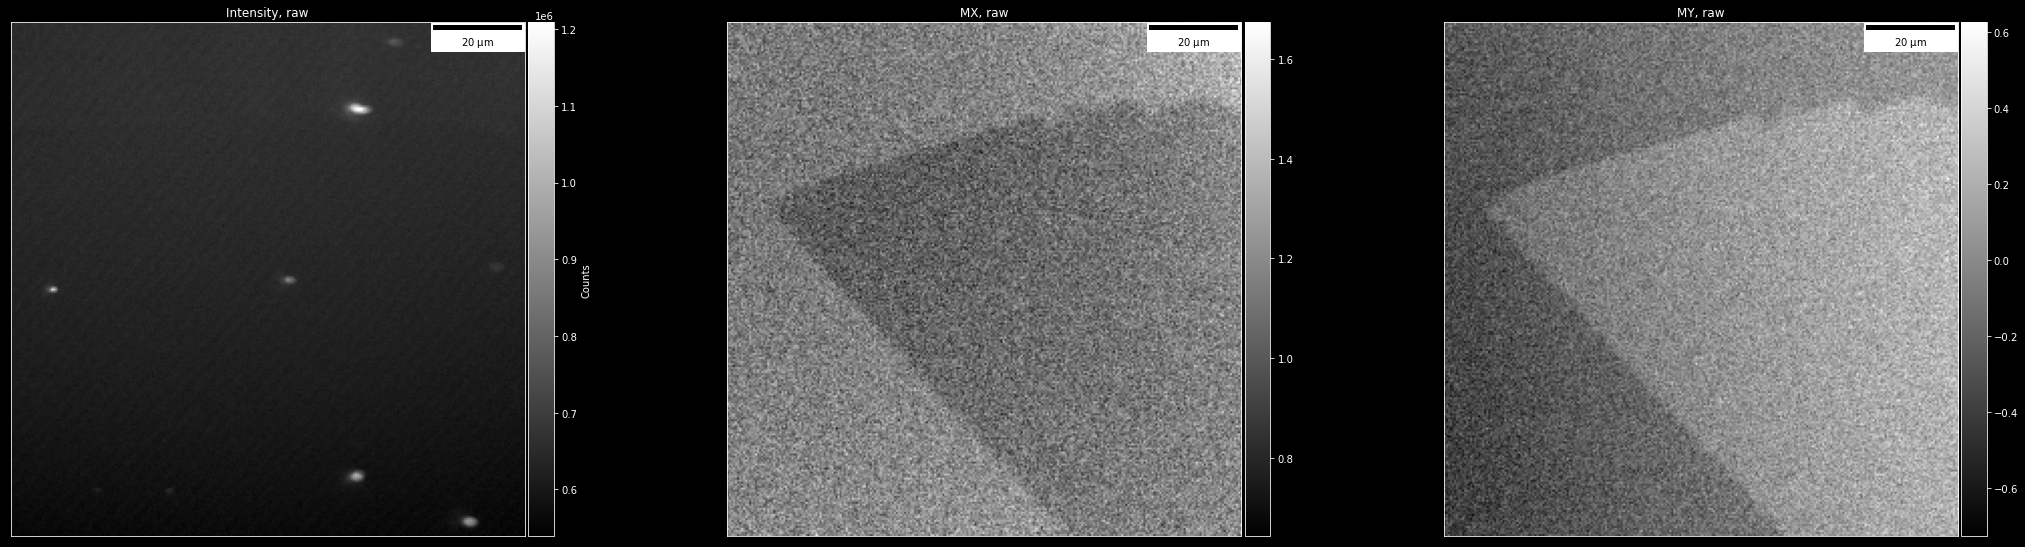

In [4]:
# Have a look at the input files

fig = plt.figure(figsize=(30, 15));

ax1 = show_subplot_raw(intensity, 2, 3, 1, 'Intensity, raw');
ax1.add_artist(ScaleBar(scale));

# Add a colorbar for counts
sm1 = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(intensity.min(), intensity.max()))
divider1 = make_axes_locatable(ax1);
cax1 = divider1.append_axes('right', size='5%', pad=0.05);
sm1.set_array([]);
cbar1 = plt.colorbar(sm1, cax=cax1, orientation='vertical');
cbar1.set_label('Counts')

ax2 = show_subplot_raw(m_1, 2, 3, 2, 'M{}, raw'.format(axis_1));
ax2.add_artist(ScaleBar(scale));

sm2 = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(m_1.min(), m_1.max()))
divider2 = make_axes_locatable(ax2);
cax2 = divider2.append_axes('right', size='5%', pad=0.05);
sm2.set_array([]);
cbar2 = plt.colorbar(sm2, cax=cax2, orientation='vertical');
#cbar2.set_label('Counts')

ax3 = show_subplot_raw(m_2, 2, 3, 3, 'M{}, raw'.format(axis_2));
ax3.add_artist(ScaleBar(scale));

sm3 = cm.ScalarMappable(cmap='gray', norm=plt.Normalize(m_2.min(), m_2.max()))
divider3 = make_axes_locatable(ax3);
cax3 = divider3.append_axes('right', size='5%', pad=0.05);
sm3.set_array([]);
cbar3 = plt.colorbar(sm3, cax=cax3, orientation='vertical');
#cbar3.set_label('Counts')

plt.tight_layout();

# Find offsets

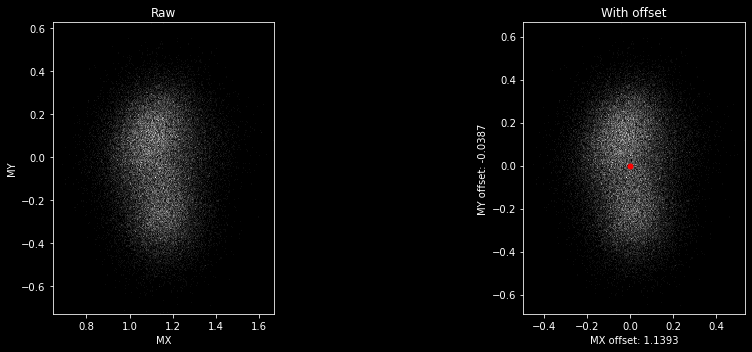

In [5]:
# Use centroid finding to get the offsets to center around 0

m1_cm, m2_cm = find_offsets(m_1, m_2)

fig = plt.figure(figsize=(15, 5));
ax1 = fig.add_subplot(1, 2, 1);
ax2 = fig.add_subplot(1, 2, 2);

ax1.hist2d(m_1.ravel(), m_2.ravel(), bins=256, cmap='gray');
ax1.set_xlabel('M{}'.format(axis_1));
ax1.set_ylabel('M{}'.format(axis_2));
ax1.set_title('Raw');
ax1.set_aspect('equal');

ax2.hist2d(m_1.ravel() - m1_cm, m_2.ravel() - m2_cm, bins=256, cmap='gray');
ax2.plot(0, 0, 'r.', ms=10);
ax2.set_xlabel('M{} offset: {:.4f}'.format(axis_1, m1_cm));
ax2.set_ylabel('M{} offset: {:.4f}'.format(axis_2, m2_cm));
ax2.set_title('With offset');
ax2.set_aspect('equal');

plt.tight_layout();

# Apply offsets and denoise files

In [6]:
# Apply offset

m_1_zeroed = m_1 - m1_cm
m_2_zeroed = m_2 - m2_cm

print('M{} zeroed - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_1, m_1_zeroed.min(), m_1_zeroed.max(), np.average(m_1_zeroed), np.ptp(m_1_zeroed)))
print('M{} zeroed - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_2, m_2_zeroed.min(), m_2_zeroed.max(), np.average(m_2_zeroed), np.ptp(m_2_zeroed)))

# Remove gradient and noise

m_1_flat, m_1_denoised = clean_image(m_1_zeroed, sigma=sigma)
m_2_flat, m_2_denoised = clean_image(m_2_zeroed, sigma=sigma)

print('M{} denoised - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_1, m_1_denoised.min(), m_1_denoised.max(), np.average(m_1_denoised), np.ptp(m_1_denoised)))
print('M{} denoised - min: {:.2f}, max: {:.2f}, average: {:.2f}, PtP: {:.2f}'.format(
    axis_2, m_2_denoised.min(), m_2_denoised.max(), np.average(m_2_denoised), np.ptp(m_2_denoised)))

# Extract contrast and phase information

contrast = get_contrast(m_1_denoised, m_2_denoised)
phase_intensities = get_phase_intensities(m_1_denoised, m_2_denoised)

MX zeroed - min: -0.50, max: 0.53, average: -0.00, PtP: 1.03
MY zeroed - min: -0.69, max: 0.67, average: -0.00, PtP: 1.35
MX denoised - min: -0.11, max: 0.17, average: -0.00, PtP: 0.28
MY denoised - min: -0.13, max: 0.12, average: -0.00, PtP: 0.25


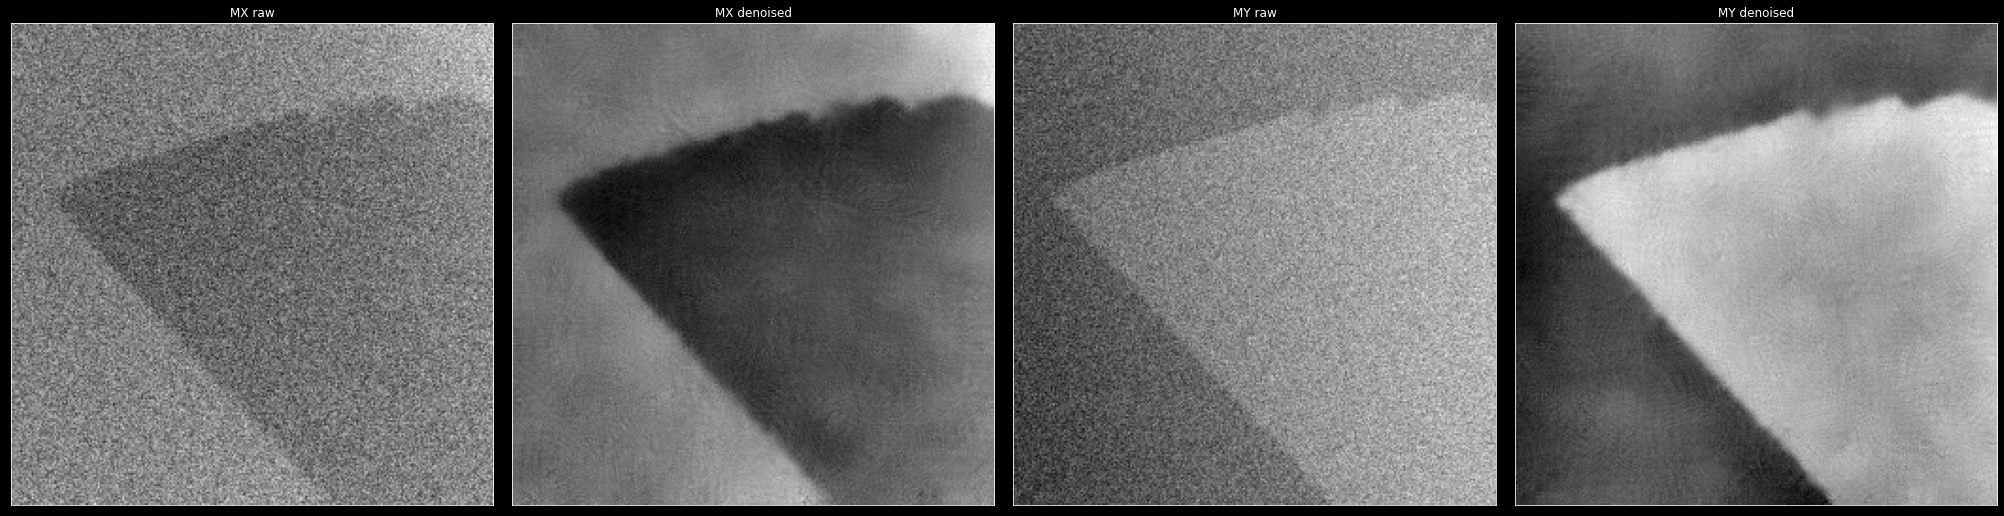

In [7]:
plt.figure(figsize=(28, 7));

show_subplot_raw(m_1, 1, 4, 1, 'M{} raw'.format(axis_1));
show_subplot_raw(m_1_denoised, 1, 4, 2, 'M{} denoised'.format(axis_1));

show_subplot_raw(m_2, 1, 4, 3, 'M{} raw'.format(axis_2));
show_subplot_raw(m_2_denoised, 1, 4, 4, 'M{} denoised'.format(axis_2));

plt.tight_layout();

# Display results

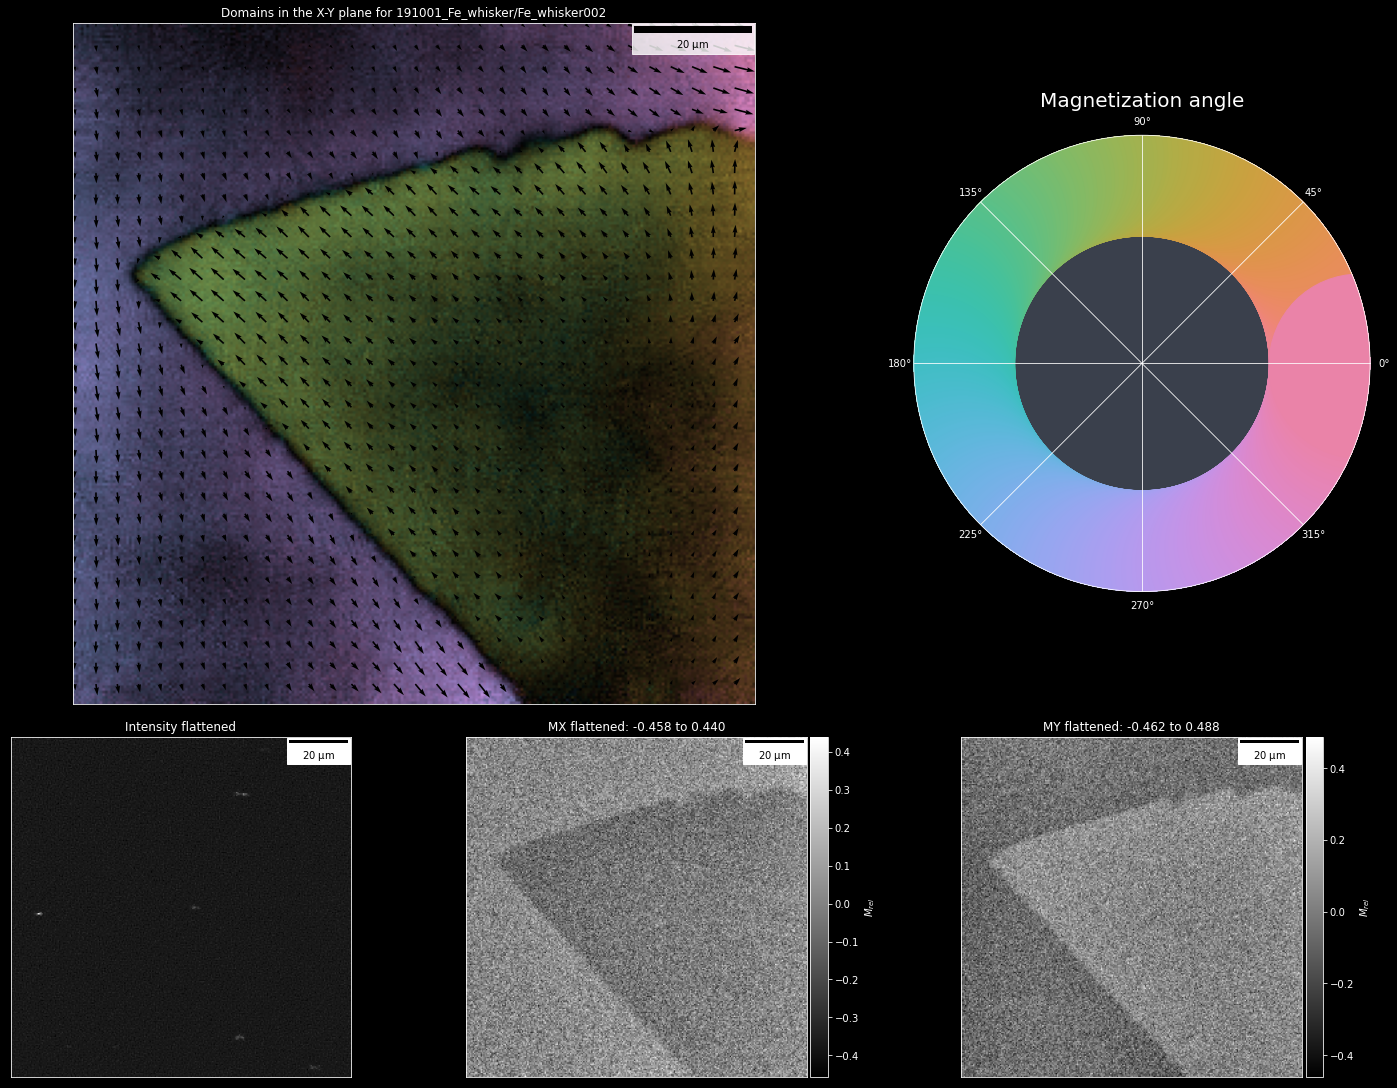

In [8]:
# Show a colorized version of the domains

img_contrast_phase = combine_phase_and_contrast(phase_intensities, contrast)

display_results(img_contrast_phase, m_1_denoised, m_1_flat, m_2_denoised, m_2_flat, intensity_flat, scale, full_name, axis_1, axis_2)

In [9]:
save_file(file, img_contrast_phase, axis_1, axis_2, scale)